This notebook simulates a population of binary stars, then maps to the data which would apprear in a typical Robo-AO cataloug through a series of transformations.

Each bolded markdown label cooresponds to the steps outlined in Fig 1 of this paper: https://arxiv.org/pdf/1911.12337.pdf

In [1]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import numpy as np
import pandas as pd
import random

%matplotlib inline

# Population

Simulating the physical properties of systems:

In [2]:
# Simulate a sample of 2000
n = 2000

In [3]:
# SEPARATIONS (AU)

# modeled as a gamma distribution
n = 2000
gamma_mean = 40
gamma_width = 30

# Defining  alpha and beta, parameters of the gamma dist in pymc3
gamma_a = gamma_mean**2 / gamma_width**2
gamma_b = gamma_mean / gamma_width**2

# Defining gamma shape (k) and scale (theta), params of np.random.gamma
k = gamma_a
theta = 1/gamma_b

sep_physical = np.random.gamma(k, theta, size=n)

In [4]:
# INVERTED MASS RATIOS and MASS RATIOS

# Modeled as a Pareto distribution
# Define Pareto shape (a) and scale/minimum (m)
a = 1.2
m = 1

mass_ratios_inverted = (np.random.pareto(a, size=n) + 1)*m
mass_ratios = 1/mass_ratios_inverted

In [5]:
# DISTANCES (PARSECS)
# Limiting to 100 pc around us, the distances should follow a power law with index 2, as n increases with r^2
dist_physical  = np.random.power(2, size=n)*100               # in parsecs   

# PARALLAX
dist_parallax = 1/dist_physical

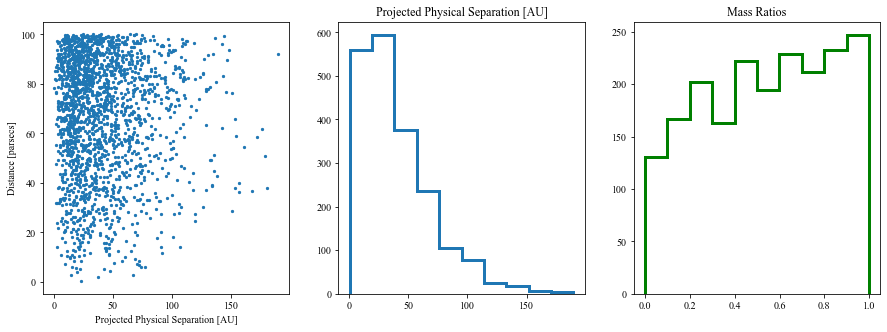

In [6]:
# Look at the distributions of the physical parameters of the systems
fig = plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(sep_physical, dist_physical, s=5)
plt.xlabel('Projected Physical Separation [AU]')
plt.ylabel('Distance [parsecs]')

plt.subplot(132)
plt.hist(sep_physical, bins=10, histtype='step', linewidth=3)
plt.title('Projected Physical Separation [AU]');

plt.subplot(133)
plt.title('Mass Ratios')
plt.hist(mass_ratios, histtype='step', color='g', linewidth=3);

# Observables

## Mapping

**Separations:**

$\text{parallax }["] =\frac{1}{\text{distance }[pc] }$

$\text{angular separation }["] = \big(\text{physical separation }[AU]\big)\ \  x\ \ \big(\text{parallax }["]\big)$


**Contrast Ratios:**

From section 4.4 of (Lamman et al), we have an emperical relationship between the inverse mass ratio ($\frac{1}{R_m}$) and inverse Robo-AO contrast ratio ($\frac{1}{R_c}$), given by a 4th degree polynomial:

$1/R_c = 20.3 - 63.1(1/R_m) + 72.5(1/R_m)^2 -40.4(1/R_m)^3  +10.6(1/R_m)^4$

In [7]:
# from inverse mass ratios to inverse contrast ratios
# this is an empirical relationship based on the results from (Lamman et al.) Section 4.4
def imr_to_icr(x):
    g = np.poly1d([ 20.34258759, -63.07636188,  72.52402942, -40.42916102, 10.64895881])
    return 1 / g(1/x)

In [8]:
# TRANSFORM PHYSICAL SEPARATIONS TO ANGULAR SEPARATIONS
sep_angular = sep_physical / dist_physical

# TRANSFORM INVERSE MASS RATIOS TO INVERSE CONTRAST RATIOS
contrast_ratios_inverted = imr_to_icr(mass_ratios_inverted)
contrast_ratios = 1/contrast_ratios_inverted

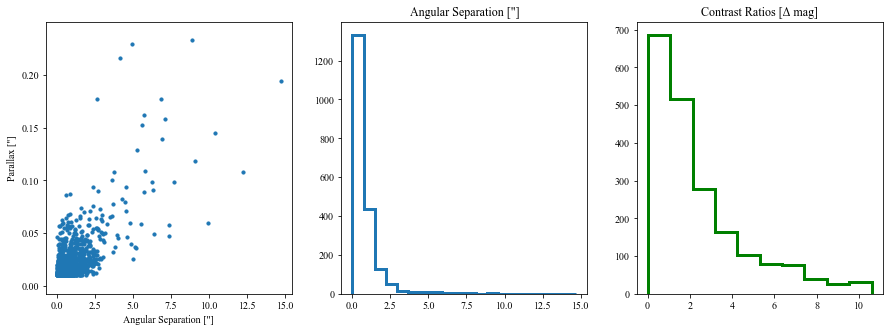

In [9]:
# Look at the distributions of the observable parameters of the systems
fig = plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(sep_angular, dist_parallax, s=10)
plt.xlabel('Angular Separation ["]')
plt.ylabel('Parallax ["]')

plt.subplot(132)
plt.hist(sep_angular, bins=20, histtype='step', linewidth=3)
plt.title('Angular Separation ["]');

plt.subplot(133)
plt.title(u'Contrast Ratios [Δ mag]')
plt.hist(contrast_ratios, histtype='step', color='g', linewidth=3);

# Measurements

**MAPPING**

Robo-AO Errors for all angular separations $\approx 0.07"$

Gaia parallax errors $\approx 0.005$ (Max is $\sim 0.015$, but will ignore parallax errors for now)

Here I'll just use a rought estimate of typical Robo-AO contrast errors. I'll model it as mostly random but higher for systems at close separations.

In [10]:
# ADD ERRORS FOR MEASURED SEPARATIONS AND MEASURED CONTRAST RATIOS

# Separations
sep_ang_e = 0.07

# Contrasts
cr_err = np.random.random_sample((len(contrast_ratios),))/10
cr_err = (cr_err/(sep_angular))*np.random.random()

In [11]:
# SAMPLE THE MEASURED SEPARATIONS AND MEASURED CONTRAST RATIOS FROM GAUSSIANS AROUND THE OBSERVABLE SEPs AND CRs

sep_measured = np.random.normal(loc=sep_angular, scale=sep_ang_e)
cr_measured = np.random.normal(loc=contrast_ratios, scale = cr_err)

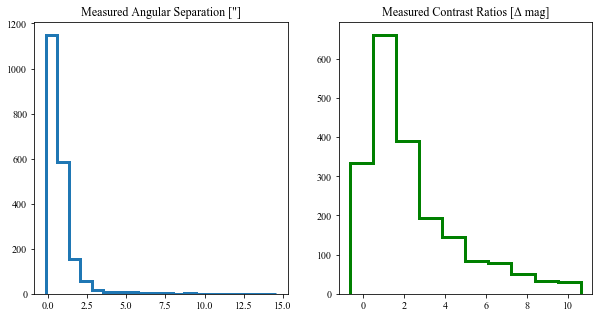

In [12]:
# Look at distributions of measured parameters
fig = plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.hist(sep_measured, bins=20, histtype='step', linewidth=3)
plt.title('Measured Angular Separation ["]');

plt.subplot(122)
plt.title(u'Measured Contrast Ratios [Δ mag]')
plt.hist(cr_measured, histtype='step', color='g', linewidth=3);

# Catalog

**MAPPING**
 
Robo-AO will generally only detect a companion if:

1. $(\text{angular separation})\  < 4.0"$   (Survey only looked within $4"$, 0.1" is )


2. $(\text{Robo-AO contrast})\  < 1.8\ \ln{(\text{angular separation ["])}} + 3.8$<br>
_This is a ROUGH model of a typical Robo-AO contrast curve, and should be improved in the future by creating a model based on the average contrast curve of each observation in the survey, or take into account individual contrast curves._

In [13]:
# LIMITS FOR WHAT WILL APPEAR IN THE FINAL DATA

# limits for separations
sep_ang_max = 4.0
sep_ang_min = 0.1

# limit for contrast ratio
# this is a rough approximation made by eye - should eventually be updated
def cr_max(separation):
    return 1.8 * np.log(separation) + 3.8

In [14]:
measurements = pd.DataFrame({'asep':sep_measured,'asep_err':[sep_ang_e]*len(sep_angular),
                                 'cr':cr_measured, 'cr_err':cr_err,
                                 'parallax':dist_parallax})

# Apply the observational limitations to get our synthetic catalog
catalog = measurements.loc[(measurements['asep']<sep_ang_max) & (measurements['asep']>sep_ang_min) &
                           (measurements['cr']<cr_max(measurements['asep']))]

C:\Users\Claire\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


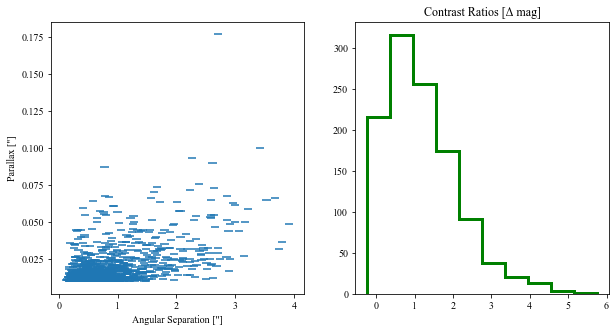

In [15]:
fig = plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.errorbar(catalog['asep'], catalog['parallax'], xerr=sep_ang_e, ls='none') #yerr=dist_parallax_e
plt.xlabel('Angular Separation ["]')
plt.ylabel('Parallax ["]')

plt.subplot(122)
plt.title(u'Contrast Ratios [Δ mag]')
plt.hist(catalog['cr'], histtype='step', color='g', linewidth=3);

## "Recreating" Fig 6 in the original survey paper
https://arxiv.org/pdf/2001.05988.pdf

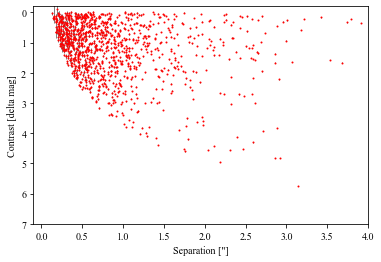

In [18]:
plt.errorbar(catalog['asep'], catalog['cr'], yerr=catalog['cr_err'], 
             marker='.', mec='r', ms=2, ls='none', linewidth=1, ecolor='grey')
plt.ylim(7, -0.2); plt.xlim(-0.1, 4)
plt.xlabel('Separation ["]'); plt.ylabel('Contrast [delta mag]');